##U-Net Architecture Implementation for Semantic Segmentation on teeth X-Ray Images

Student Name: Yassin Dinana

Student ID: 52094480

##Importing Libraries

In [1]:
import numpy as np #NumPy library used for processing matrices 
import matplotlib.pyplot as plt #Matplot Library used for plots and images printing in the notebook code. 
import os #For using operating system dependent functionalities
import pandas as pd #Used to load the data and splitting
from PIL import Image #Used for data loading and images processing
import keras #Main libary used to load the models and build NN. 
from keras.models import Model #Importing the model and training 
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D #Required packages for building neural network layers. 
from keras.layers import  Dropout, Activation #Packages for dropout and activation layers. 
from tensorflow.keras.optimizers import Adam, SGD #Used for model optimzing and evaluatin
from keras.layers.advanced_activations import LeakyReLU #Used for activation layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #Used in the callbacks funtion to apply checkpoints and early stopping techniques
from keras import backend as K #Using the Keras backend code to optimize models. 
from tensorflow.keras.utils import plot_model #Used to plot the model in the notebook (Seen below)
import tensorflow as tf #Importing tensorflow - main library for Keras used to build models
import glob #Used to return file paths to their original patterns
import random #Used to choose random batches from the dataset
import cv2 #Main library used for all computer vision applications
from random import shuffle #Shuffles the dataset before choosing random dataset batches

##Loading and Pre-Processing data

In [2]:
#Function for images generation and dataset loading. The batch size is set to 32 and the input image size is of Height = 256, Widht = 256, RGB. 
def images_gen(files, batch_size = 16, image_size = (256, 256)):
  while True: 
    random_batch = np.random.choice(files, size = batch_size) #Choose a random batch from the dataset     
    
    input_batch = [] #List for collecting input batches
    output_batch = [] #List for collecting output batches
    
    for f in random_batch:
        mask_images = Image.open(f'/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/masks/{f[:-4]}.png') #Loading all masks images from the dataset on Google Drive
        mask_images = np.array(mask_images.resize(image_size)) #Setting all masks to a numpy array with the given image size.

        #Applying conditions on input array for the Mask Images
        mask_images[mask_images >= 2] = 0 
        mask_images[mask_images != 0 ] = 1
        output_batch.append(mask_images) #Append all mask images to the Y Batch list

        #Loading Raw X-Ray images from dataset and making images a NumPy array
        raw_XRays = Image.open(f'/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images/{f}')
        raw_XRays = raw_XRays.resize(image_size)
        raw_XRays = np.array(raw_XRays)

        #Checking if number of channels is RGB or GrayScale by examining the length of the array
        if len(raw_XRays.shape) == 2:
          raw_XRays = np.stack((raw_XRays,)*3, axis=-1)
        else:
          raw_XRays = raw_XRays[:,:,0:3]
        input_batch.append(raw_XRays)

    #Pre-Processing the chosen batches on mask and raw images
    input_batch = np.array(input_batch)/255. #Apply normalization to input images to adjust intensity values
    output_batch = np.array(output_batch) 
    output_batch = np.expand_dims(output_batch,3) #Expanding the image dimensions of the output batch (Y)

    yield (input_batch, output_batch)  #Yield is similararly used as "Return" in Python. It is used to convert the function into a generator.    
    

##Splitting Data to train and test folders

In [3]:
batch_size = 16 #Batch size is adjustable when different training epochs are applied. 

#Loading all images from  Google Colab
all_files = os.listdir('/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images')
shuffle(all_files) #Shuffle all images so different images are splitted when running this cell. 

data_splitting = int(0.95 * len(all_files)) #Defining the training set to be 95% and the Testing set to be 5% (Just for trial - This is changed and discussed in the paper)

#split into training and testing
train_files = all_files[0:data_splitting] #95% Training set - Showing 739 images
test_files  = all_files[data_splitting:] #5% Testing Set - Showing 39 images

#Calling the generator function in the previous cell to choose random batches and develop train and test generator (X and Y)
train_generator = images_gen(train_files, batch_size = batch_size) 
test_generator  = images_gen(test_files, batch_size = batch_size)

In [4]:
#This function returns the item to an iteraton
x, y= next(train_generator)

#Equation used in the following cell for sample wise normalization
*x = 1.0 × (x-np.min(x))/(np.max(x)-np.min(x))*

**np** is NumPy - Calling the NumPy library                                                                              



In [5]:
#Normalizes rach sample between 0 and 2. The input is a sample image from the dataset and the output is the normalized sample. 
def sample_wise_normalization(train_files):
    train_files.astype(np.float32)
    if np.max(train_files) == np.min(train_files):
        return np.ones_like(train_files, dtype=np.float32) * 1e-6
    else:
        return 1.0 * (data - np.min(train_files)) / (np.max(train_files) - np.min(train_files))

## Data Exploration and extra pre-processing / data cleaning

Exploring training and testing folders after splitting

In [6]:
training_length = len(train_files)
testing_length = len(test_files)

In [7]:
#Checking the length of both training and testing folders after splitting
print("The length of the training dataset is:", len(train_files), "images.")
print("The length of the training dataset is:", len(test_files), "images.")

The length of the training dataset is: 739 images.
The length of the training dataset is: 39 images.


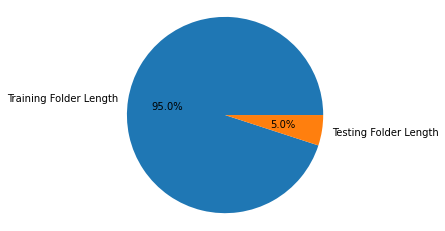

In [8]:
#Generating Pie Plot for training and testing folders length
labels=['Training Folder Length','Testing Folder Length']
sizes=[training_length, testing_length]
plt.pie(sizes,labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Explore raw image RGB input individually

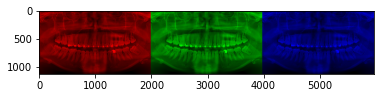

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

im = np.array(Image.open('/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images/cate1-00005.jpg'))

im_R = im.copy()
im_R[:, :, (1, 2)] = 0
im_G = im.copy()
im_G[:, :, (0, 2)] = 0
im_B = im.copy()
im_B[:, :, (0, 1)] = 0

im_RGB = np.concatenate((im_R, im_G, im_B), axis=1)
# im_RGB = np.hstack((im_R, im_G, im_B))
# im_RGB = np.c_['1', im_R, im_G, im_B]

pil_img = Image.fromarray(im_RGB)
pil_img.save('/content/drive/MyDrive/Masters Degree/Graduation Project/Code/outputs/example_image_splitColors.jpg')
plt.imshow(pil_img)

Denoising images - trial is on one image below (Removing noise from image)

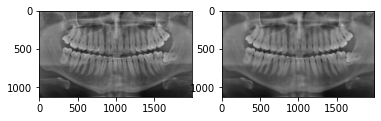

In [10]:
#figure(figsize=(12, 12), dpi=80)

img = cv2.imread('/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images/cate1-00027.jpg')

dst = cv2.fastNlMeansDenoisingColored(img,None,20,20,7,21)

plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)

plt.show()

Image Binarization Teeth are represented in white and other parts in black as teeth is the Region of Interest (ROI) and has less pixels intensity

128.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2a47e96cd0>,
 <matplotlib.image.AxesImage at 0x7f2a47de5410>)

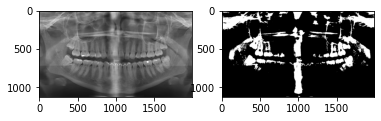

In [11]:
im = cv2.imread('/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images/cate1-00026.jpg')

th, im_th = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY)

print(th)
# 128.0

#cv2.imwrite('/content/drive/MyDrive/Masters Degree/Graduation Project/Code/outputs', im_th)
plt.subplot(121),plt.imshow(im)
plt.subplot(122),plt.imshow(im_th)

#plt.imshow(im)
#plt.imshow(im_th)

The cell below is for printing a sample from the raw image (X-Ray) and its' sample from the mask folder. Finally concatinate both to represent how the output of the model should be.

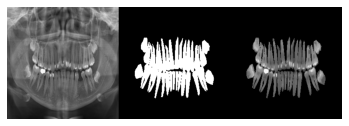

In [12]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

hello = plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

##Intersection over Union Function used for evaluation (Discussed in paper)

In [13]:
def mean_iou(y_true, y_prediction):
    chosen_axes = (1,2) 
    intersection = np.sum(np.abs(y_prediction * y_true), axis=chosen_axes) 
    mask_version = np.sum(np.abs(y_true), axis=chosen_axes) + np.sum(np.abs(y_prediction), axis=chosen_axes)
    union = mask_version - intersection
    smoothing_value = .001
    iou = (intersection + smoothing_value) / (union + smoothing_value)
    return iou

##Dice Coefficient Evaluation Metric

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

##U-Net Architecture with our parameters (Different from original architecture in the paper):

# 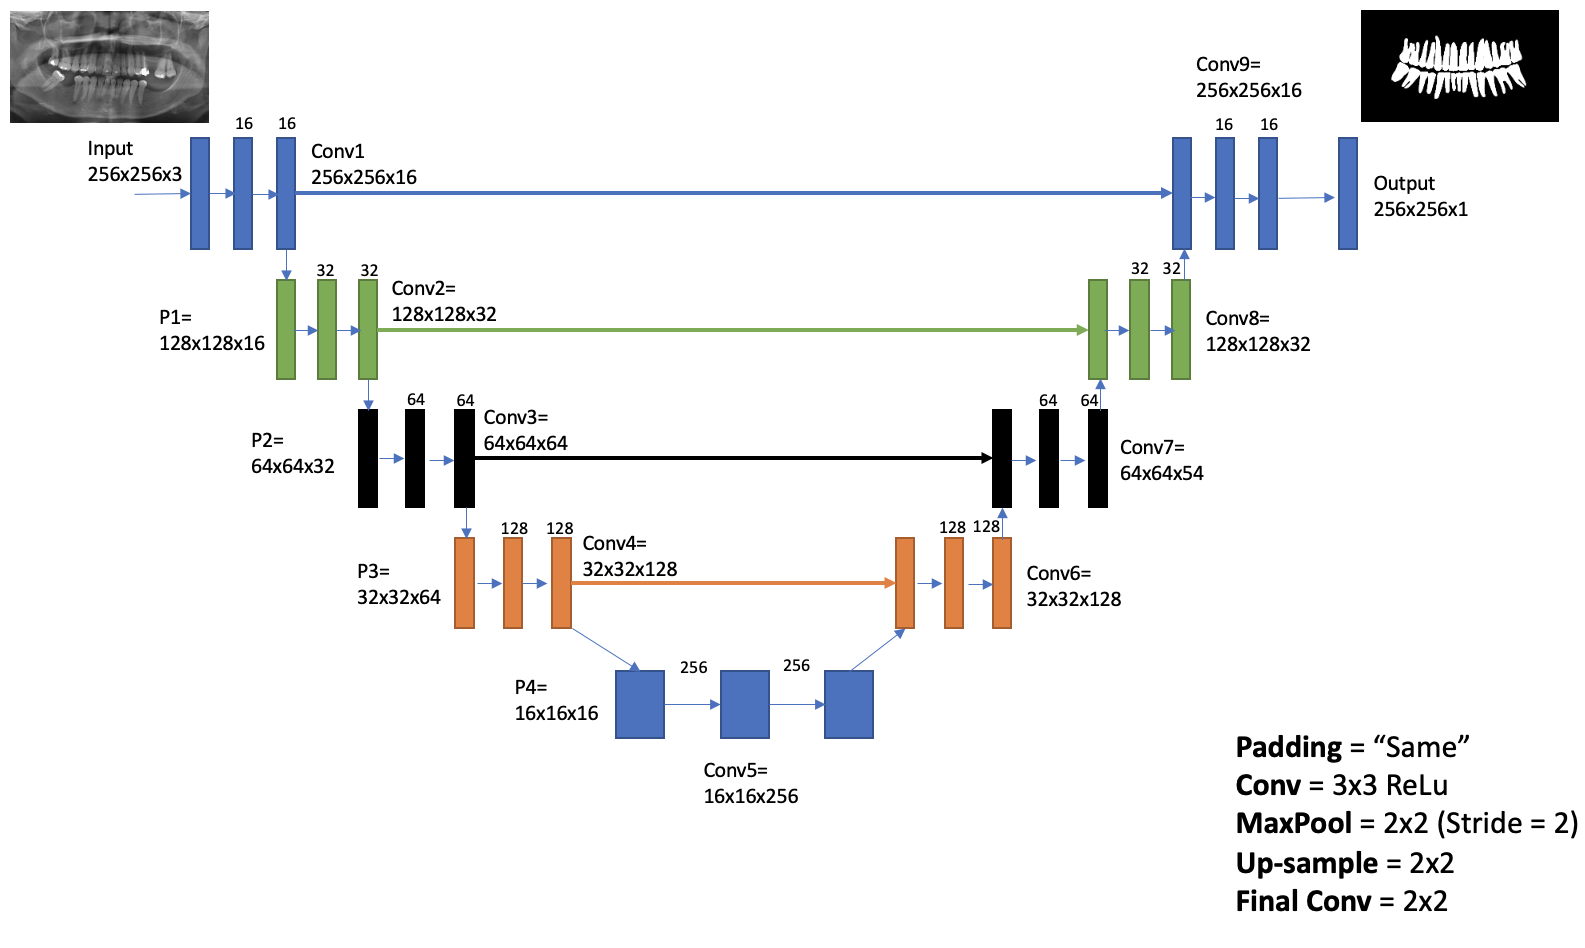

##U-Net Architecture Implementation

In [15]:
def unet_architecture(image_size = (256, 256, 3)): #Input image will be with dimensions of height = 256, width = 256, and RGB represented as 3. 
  x = Input(image_size)
  inputs = x
  #down sampling operation which is the left side of the architecture seen in the image. 
  filters = 8
  layers = [] #Empty list to append later with layers. 
  for i in range(0, 6):
    x = Conv2D(filters, 3, activation='relu', padding='same') (x)  
    x = Conv2D(filters, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    filters = filters*2
  ff2 = 64  
  #bottleneck (Represening Convolution 5 seen in the image)
  j = len(layers) - 1
  x = Conv2D(filters, 3, activation='relu', 
             padding='same') (x)
  x = Conv2D(filters, 3, activation='relu', 
             padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), 
                      padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  #upsampling (It can be seen in the image of the model above, this process is for the right side of the architecture)
  for i in range(0, 5):
    ff2 = ff2//2
    filters = filters // 2 
    x = Conv2D(filters, 3, activation='relu', 
               padding='same') (x)
    x = Conv2D(filters, 3, activation='relu', 
               padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), 
                        padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  #classification - This is for the classification of different pixels for identifying teeth.
  x = Conv2D(filters, 3, activation='relu', 
             padding='same') (x)
  x = Conv2D(filters, 3, activation='relu', 
             padding='same') (x)
  outputs = Conv2D(1, 1, 
                   activation='sigmoid') (x)
  
  #Creating the model 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy']) #Evaluating model with metric "Accuracy"
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[mean_iou])  #Evaluating model with the Mean IoU function applied in previous cell.
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[dice_coef])  #Evaluating model with the Dice Coefficient function applied in previous cell.
  
  return model

In [16]:
#Passing the U-Net architecture to the model.
model = unet_architecture()
#Printing the model summary (Can be found in the paper)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Plotting the model using TensorFlow

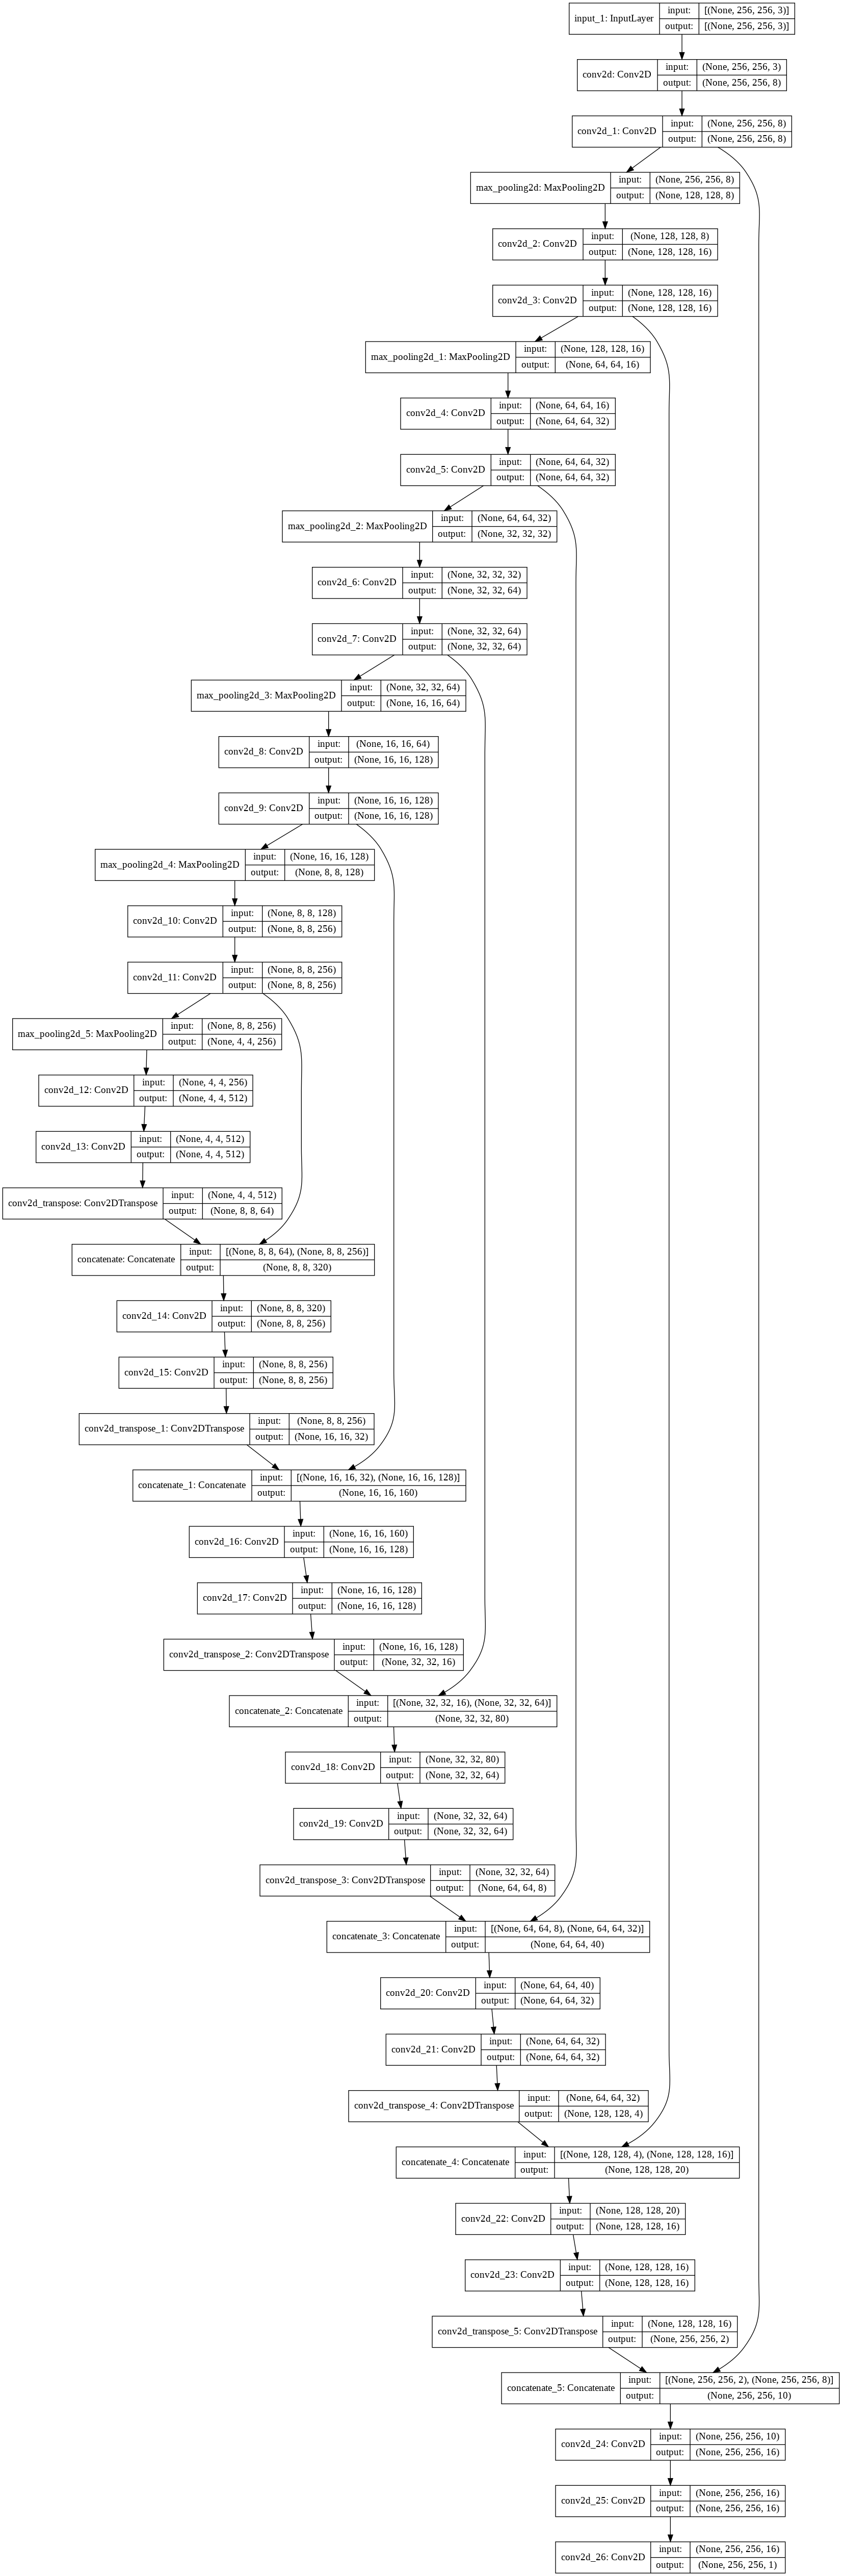

In [17]:
#Plotting the model.
img_file = './model_arch.png'
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

In [18]:
def build_callbacks(self):
        model_checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        early_stopping = EarlyStopping(monitor='validation_loss', patience=10, verbose=1)
        reducing_learing_rate = ReduceLROnPlateau(monitor='validation_loss', factor=0.5,
                    patience=3, min_lr=0.0001)
        callbacks = [model_checkpointer, reducing_learing_rate, early_stopping, PlotLearning()]
        return callbacks

In [19]:
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('validation_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou')) #Function provided earlier in the code for evaluating the model (IoU)
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'validation_loss=',logs.get('validation_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [20]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

history = model.fit(train_generator,
                    epochs = 80,
                    steps_per_epoch = train_steps,
                    validation_data = test_generator, 
                    validation_steps = test_steps,
                    verbose = 1)

Epoch 1/80
46/46 [==============================] - 42s 795ms/step - loss: 0.5502 - accuracy: 0.8003 - val_loss: 0.4669 - val_accuracy: 0.8001
Epoch 2/80
46/46 [==============================] - 36s 795ms/step - loss: 0.4563 - accuracy: 0.8003 - val_loss: 0.3815 - val_accuracy: 0.8016
Epoch 3/80
46/46 [==============================] - 36s 798ms/step - loss: 0.3080 - accuracy: 0.8488 - val_loss: 0.3324 - val_accuracy: 0.8671
Epoch 4/80
46/46 [==============================] - 36s 793ms/step - loss: 0.2145 - accuracy: 0.9059 - val_loss: 0.2010 - val_accuracy: 0.9149
Epoch 5/80
46/46 [==============================] - 36s 794ms/step - loss: 0.1862 - accuracy: 0.9204 - val_loss: 0.1688 - val_accuracy: 0.9294
Epoch 6/80
46/46 [==============================] - 36s 795ms/step - loss: 0.1710 - accuracy: 0.9273 - val_loss: 0.1591 - val_accuracy: 0.9348
Epoch 7/80
46/46 [==============================] - 36s 795ms/step - loss: 0.1552 - accuracy: 0.9349 - val_loss: 0.1405 - val_accuracy: 0.9415

In [21]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

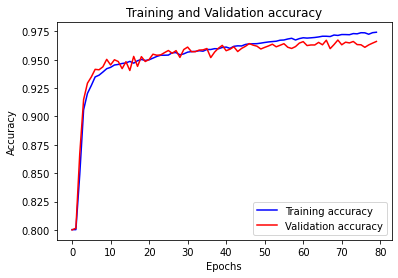

In [22]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,80)
plt.plot(epochs, loss_train, 'b', label='Training accuracy')
plt.plot(epochs, loss_val, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

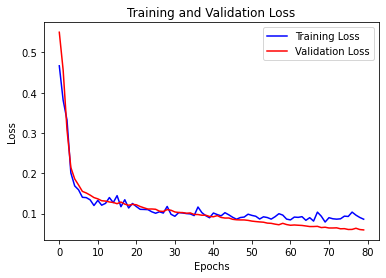

In [23]:
loss_train = history.history['val_loss']
loss_val = history.history['loss']
epochs = range(0,80)
plt.plot(epochs, loss_train, 'b', label='Training Loss')
plt.plot(epochs, loss_val, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

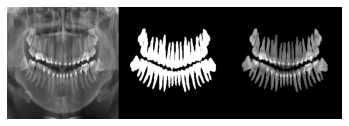

In [25]:
raw = Image.open('/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images/cate1-00054.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]
pred = model.predict(np.expand_dims(raw, 0))
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

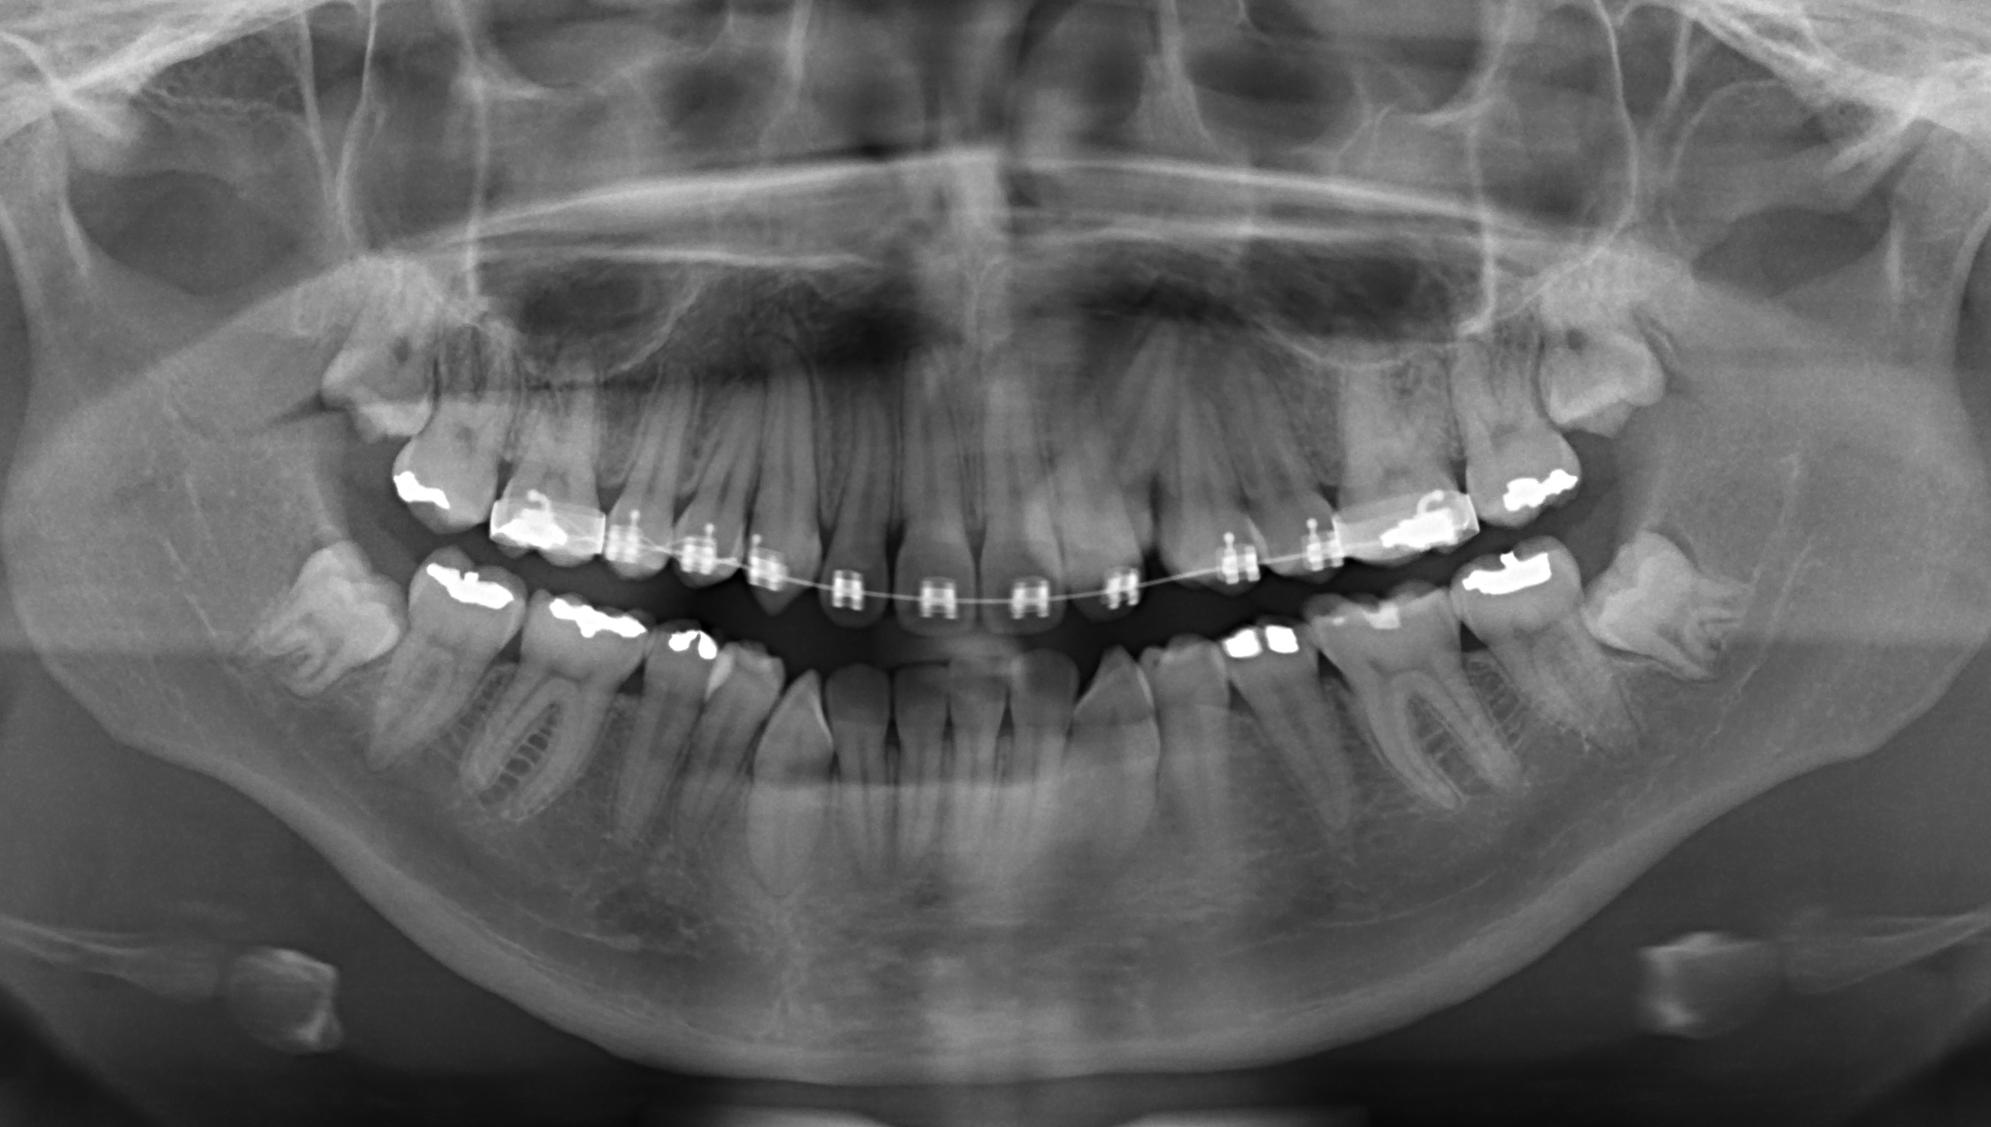

In [27]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = keras.utils.get_file(
    "/content/drive/MyDrive/Masters Degree/Graduation Project/Dataset/NEW DATA - dns-panoramic-images-ivisionlab/semantic-segmentation/images/cate1-00047.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

In [28]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n09229709', 'bubble', 7.020971)]


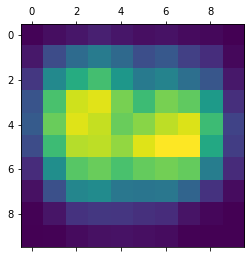

In [29]:
# Input Image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Build GradCam model 
model = model_builder(weights="imagenet")
model.layers[-1].activation = None

# Print predicted output values
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Plot heaptmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

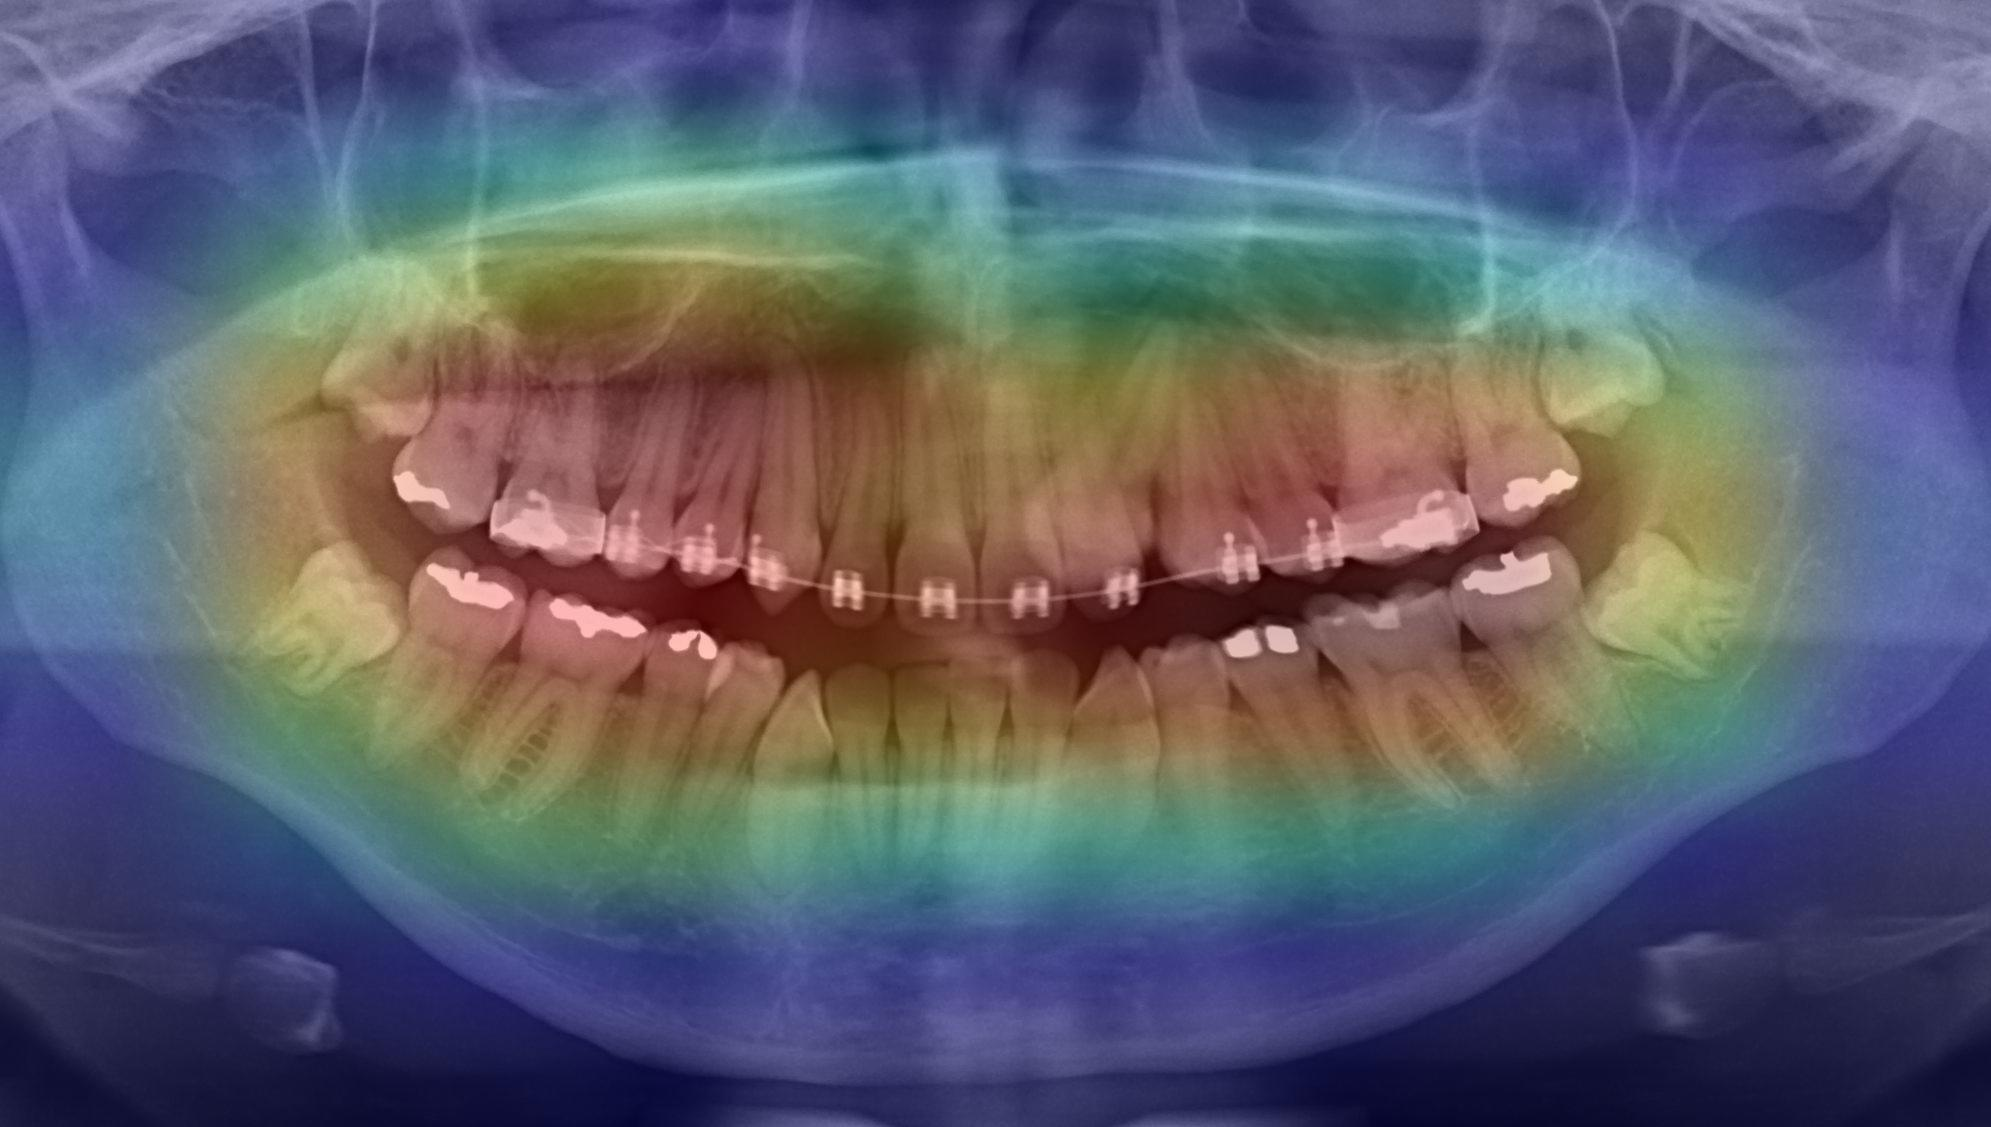

In [30]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)